## Cooling Tank Model

This notebook describes the optimization of the tank model described in `tank_model.py`. This model was developed in the fmdtools package, and requires its installation to simulate.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import scipy as sp
import time
import itertools
import random
from scipy.optimize import minimize

import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
from tank_model import Tank
from fmdtools.modeldef import SampleApproach

# Simulation

### Verifying the nominal state:

In the nominal state, no change in system state should occurs.

In [2]:
mdl = Tank()
endresults, resgraph, mdlhist = propagate.nominal(mdl)

In [3]:
mdlhist.keys()

dict_keys(['flows', 'functions', 'time'])

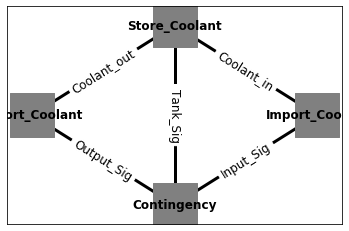

In [4]:
rd.graph.show(resgraph)

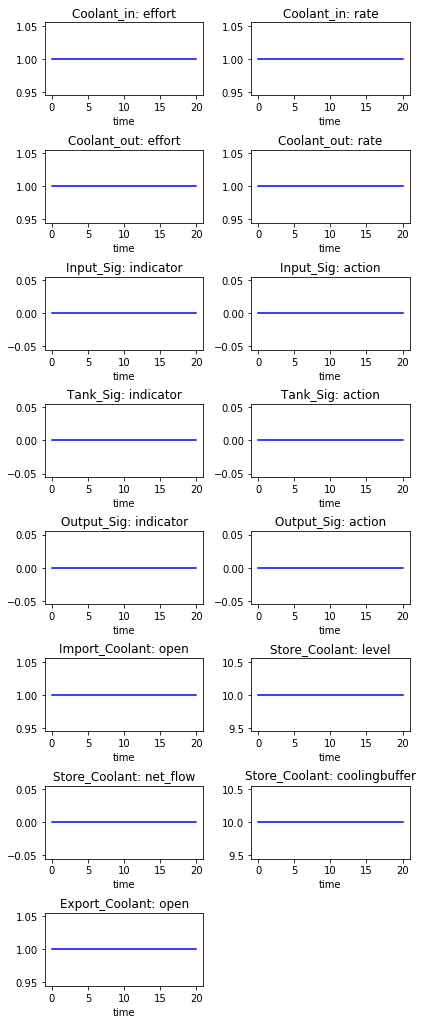

In [5]:
rd.plot.mdlhistvals(mdlhist)

### What happens under component faults?


Here we model a leak of the tank. As shown, the coolant leaks until there is no more coolant left in the tank. While this results in a warning signal, the default contingency management policy is to take no actions to alleviate the condition.

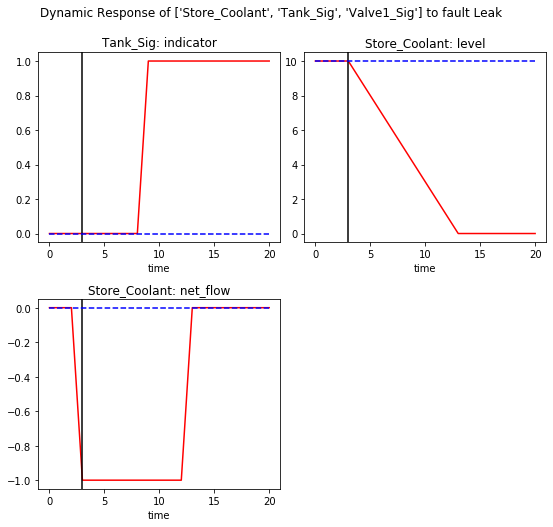

In [276]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl,'Store_Coolant','Leak', time=3)

fig = rd.plot.mdlhistvals(mdlhist, fault='Leak', time=3, fxnflowvals={'Store_Coolant':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, returnfig = True, legend=False) #,
#fig.axes[3].remove()
fig.set_figheight(8)
fig.set_figwidth(8)
fig.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.3)

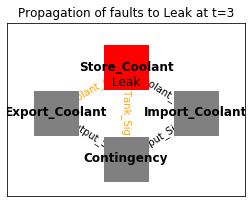

In [277]:
#add graph view to figure
graph_fig, graph_ax = rd.graph.show(resgraph,faultscen='Leak', time=3, retfig=True)
graph_ax.figure = fig
fig.axes.append(graph_ax)
fig.add_axes(graph_ax)
graph_ax.set_position([0.7,0.16,0.55,0.6])
graph_ax.margins(0.3)

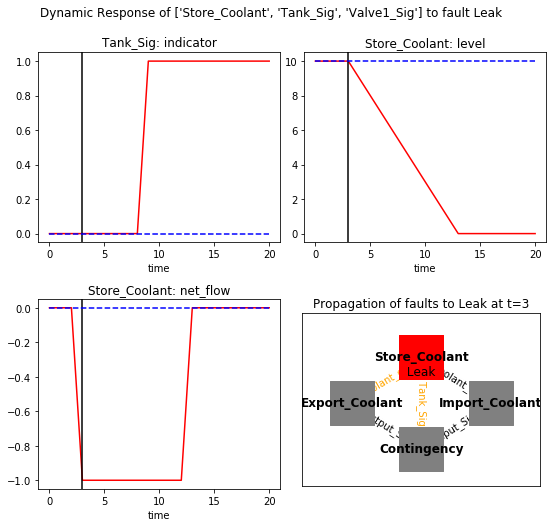

In [278]:
fig

In [204]:
fig_high_degree_nodes.savefig('tank_behavior', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

Bbox([[0.5704571759259259, 0.14236111111111116], [0.9768518518518517, 0.4141999748617396]])

In [182]:
f = fig.axes[1].get_position()
f

Bbox([[0.5704571759259259, 0.6031611362493716], [0.9768518518518517, 0.875]])

In [183]:
dir(f)

['INVALID',
 'INVALID_AFFINE',
 'INVALID_NON_AFFINE',
 '__array__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_gid',
 '_ignore',
 '_invalid',
 '_invalidate_internal',
 '_minpos',
 '_parents',
 '_points',
 '_points_orig',
 '_shorthand_name',
 'anchored',
 'bounds',
 'coefs',
 'contains',
 'containsx',
 'containsy',
 'corners',
 'count_contains',
 'count_overlaps',
 'expanded',
 'extents',
 'from_bounds',
 'from_extents',
 'frozen',
 'fully_contains',
 'fully_containsx',
 'fully_containsy',
 'fully_overlaps',
 'get_points',
 'height',
 'ignore',
 'intersection',
 'intervalx',
 'intervaly',
 'invalidat

In [177]:
fig.axes[2].get_position()

Bbox([[0.09548611111111112, 0.14236111111111116], [0.501880787037037, 0.4141999748617396]])

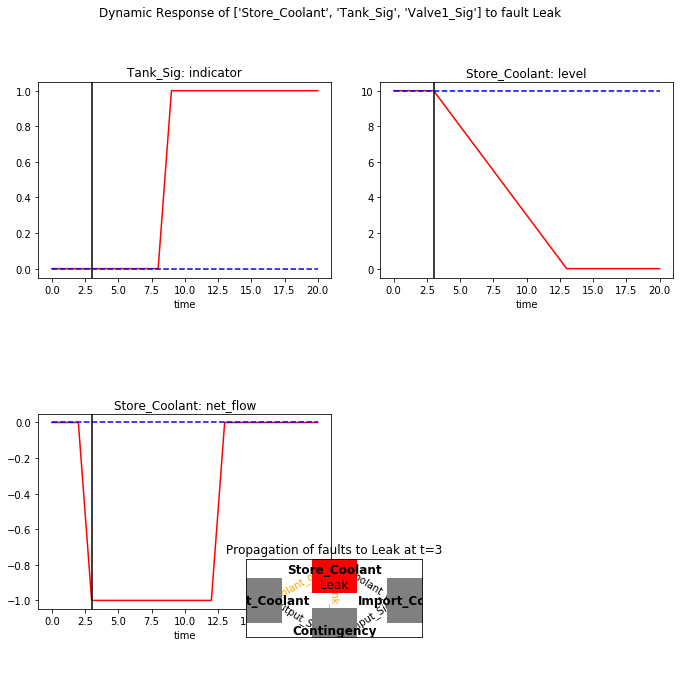

In [173]:
fig

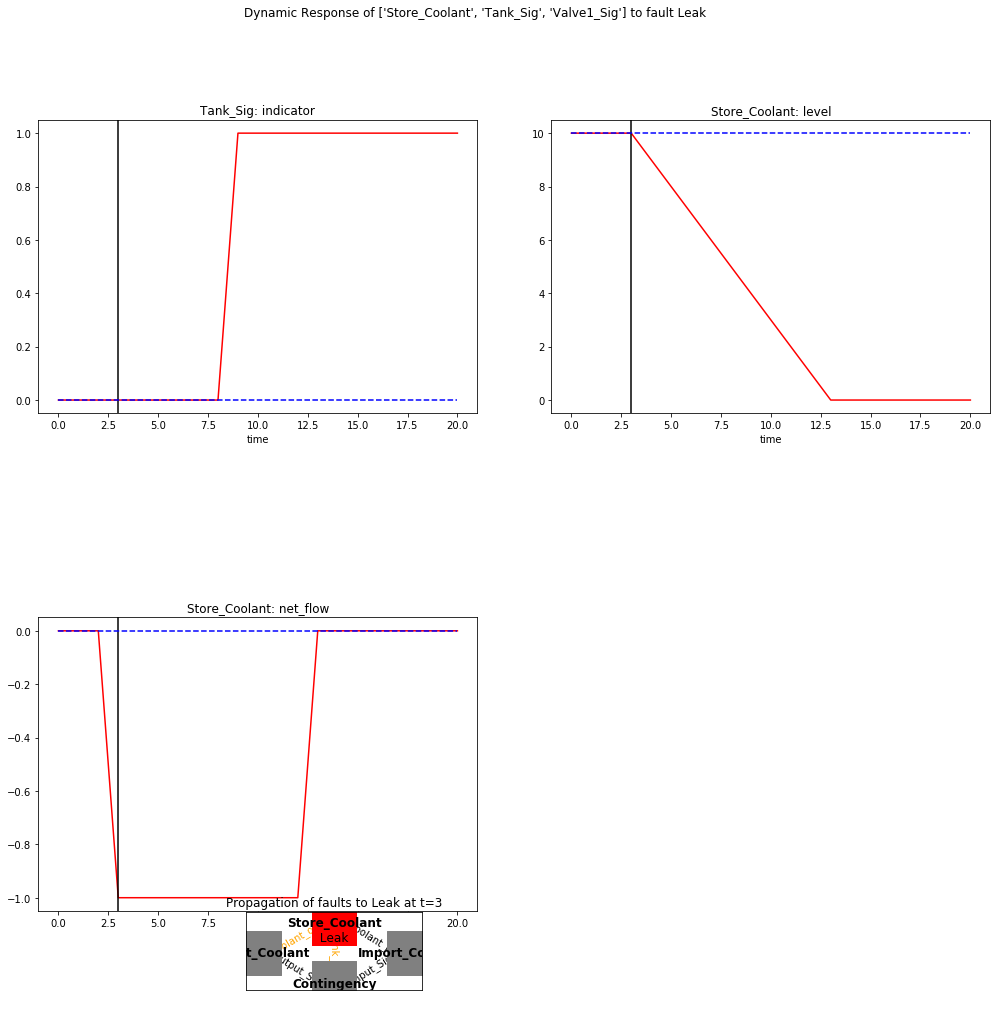

In [145]:
fig

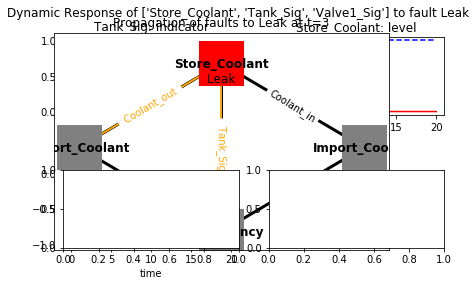

In [108]:
fig

### Full set of modes

The tank leak mode will not be the only mode considered, but also leak and blockage faults in the Imput/Output blocks.

In [10]:
app_joint_faults = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)
fmea_tab = rd.tabulate.simplefmea(endclasses)
fmea_tab

,rate,cost,expected cost
"Import_Coolant Leak, t=0",0.000002,2100000.0,350000.000000
"Import_Coolant Blockage, t=0",0.000002,2100000.0,350000.000000
"Store_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Blockage, t=0",0.000002,100000.0,16666.666667
